In [22]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [23]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [24]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text

In [25]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [27]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(engine, reflect=True)

In [28]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [29]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [30]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [31]:
# Note: to read in entire Tables as Dataframes:
measurement_df = pd.read_sql('SELECT * FROM measurement', conn)

# Note: can also set index when defining Dataframe
station_df = pd.read_sql('SELECT * FROM station', conn).set_index('id')
station_df

,station,name,latitude,longitude,elevation
id,,,,,
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,0.914
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,4.450
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,2.133
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,3.627
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,93.447
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,5.943
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,10.027
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.274
8,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,46.449


# Exploratory Precipitation Analysis

In [52]:
# Find the most recent date in the data set.
most_recent = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
print(most_recent)

# or

print(most_recent.date)

('2017-08-23',)
2017-08-23


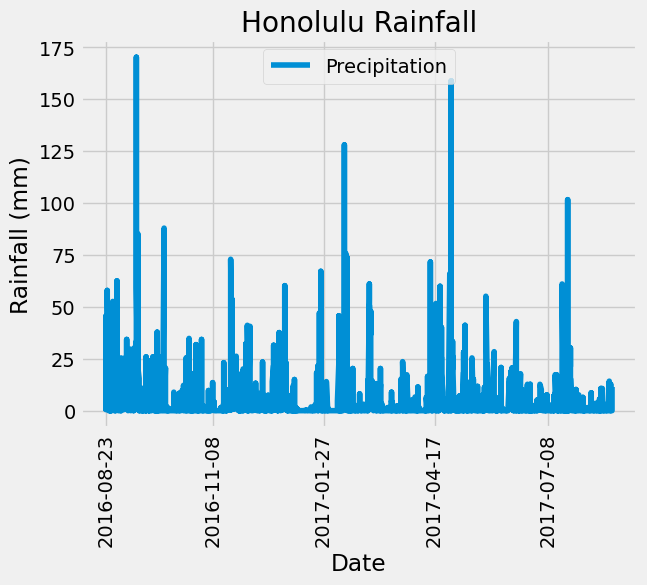

In [34]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
latest_date = most_recent.date

# Split date into year, month and day variables
y, m, d = latest_date.split('-')
# Convert variables to integer type
y, m, d = int(y), int(m), int(d)

# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(y, m, d) - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores
rain_query = session.query(Measurements.date, Measurements.prcp).\
                     filter(Measurements.date >= one_year_ago).\
                     filter(Measurements.date <= latest_date).all()

# Or:

query = text(f"SELECT measurement.date, measurement.prcp FROM measurement \
             WHERE date BETWEEN '{one_year_ago}' AND '{latest_date}';")
data = engine.execute(query)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
recent_rain_df = pd.DataFrame(rain_query, columns=['Date', 'Precipitation'])

# Sort the dataframe by date and drop NaNs
recent_rain_clean_df = recent_rain_df.sort_values(['Date']).dropna()

# Set index to Date for Pandas.plot (please see code cell below)
recent_rain_date_index_df = recent_rain_clean_df.set_index(['Date'])

# Drop Date index for Matplotlib plot
recent_rain_final_df = recent_rain_date_index_df.reset_index()

# Use Pandas Plotting with Matplotlib to plot the data
# Define x- and y-axes
x = recent_rain_final_df['Date']
y = recent_rain_final_df['Precipitation']

# Plot line graph
plt.plot(x, y, label="Precipitation")

# Set x-ticks on x-axis (show every 450th Date as tick, rotate label by 90 degrees)
plt.xticks(x[::450],  rotation=90)

# Set title and axis labels
plt.title('Honolulu Rainfall')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend(loc='upper center')

# Show plot
plt.show()


Text(0.5, 0, 'Date')

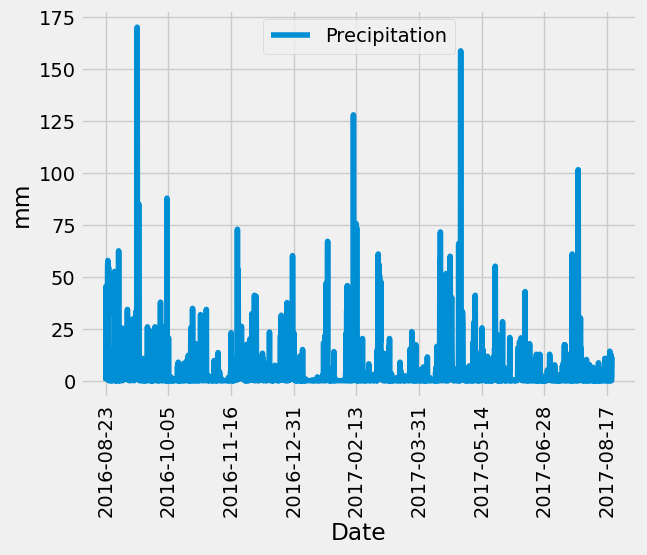

In [35]:
# Use Pandas.plot to plot the data
recent_rain_plot = recent_rain_date_index_df.plot.line(rot=90)
recent_rain_plot.set_ylabel("mm")
recent_rain_plot.set_xlabel("Date")

In [36]:
# Use Pandas to calculate the summary statistics for the precipitation data
recent_rain_final_df.describe()

,Precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [37]:
# Design a query to calculate the total number of stations in the dataset
number_stations_query = session.query(Stations.station).count()

# Or:

stations_df = pd.read_sql(f"SELECT * FROM station;", conn)
len(stations_df['station'])

number_stations_query

9

In [38]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurements.station, func.count(Measurements.station)).\
                                group_by(Measurements.station).\
                                order_by(func.count(Measurements.station).desc()).all()



# Note: could also do it this way:

most_active_stations_other = text(f'SELECT station, COUNT(station)\
                                   FROM Measurement\
                                   GROUP BY station\
                                   ORDER BY COUNT(station) DESC;')

active_station_data = engine.execute(most_active_stations_other)

# Note: to print this remove '#' from below code:
#for record in active_station_data:
    #print(record)

most_active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [39]:
# Create variable for most active station
most_active_station = most_active_stations[0][0]

most_active_station

'USC00519281'

In [40]:
# Can also create variable for most active station using the second method shown above:
active_station_data = engine.execute(most_active_stations_other)
most_active_station_other = active_station_data.first()[0]

most_active_station_other

'USC00519281'

In [41]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_stats = [func.min(Measurements.tobs),
              func.max(Measurements.tobs),
              func.avg(Measurements.tobs)]

station_stats = session.query(*temp_stats).\
                filter(Measurements.station == most_active_station).\
                order_by(Measurements.station).all()

# Or:

station_data = text(f'SELECT min(tobs), max(tobs), avg(tobs)\
                      FROM Measurement\
                        WHERE station = "{most_active_station}";')

station_data_query = engine.execute(station_data)

station_stats

[(12.2, 29.4, 22.03582251082252)]

In [42]:
# Determine most recent entry date for most active station
most_recent_date_station1 = session.query(Measurements.date).\
                            filter(Measurements.station == most_active_station).\
                            order_by(Measurements.date.desc()).first()

# Or:

station_temp_df = pd.read_sql(f"SELECT date, tobs\
                                FROM measurement\
                                    WHERE station = '{most_active_station}';", conn)

most_recent_date_station2 = station_temp_df['date'].values[-1:]


print(most_recent_date_station1[0])
print(most_recent_date_station2[0])


2017-08-18
2017-08-18


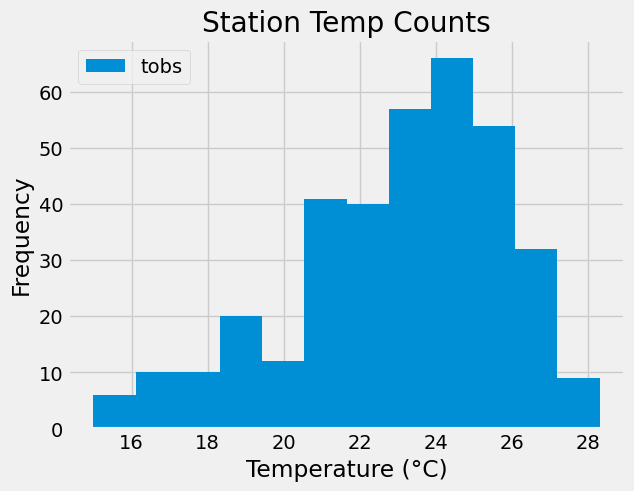

In [43]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Most recent data point for station 
latest_date = most_recent_date_station1[0]

# Split date into year, month and day variables
y, m, d = latest_date.split('-')
# Convert variables to integer type
y, m, d = int(y), int(m), int(d)

# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(y, m, d) - dt.timedelta(days=365)

# Get temperatures for most active station over the last 12 months
station_temps = session.query(Measurements.tobs).\
                        filter(Measurements.station == most_active_station).\
                        filter(Measurements.date >= one_year_ago).\
                        filter(Measurements.date <= latest_date).\
                        order_by(Measurements.date.desc()).all()

# Or:

station_temp_df = pd.read_sql(f"SELECT tobs\
                                FROM measurement\
                                    WHERE station = '{most_active_station}'\
                                    AND date BETWEEN '{one_year_ago}' AND '{latest_date}';", conn)

# Plot Histogram with correct binning
plt.hist(station_temp_df, label='tobs', bins=12)

# Set title and axis labels
plt.title('Station Temp Counts')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.legend(loc='upper left')

In [51]:
# EXTRA: Query all stations 
station_query = session.query(Stations.station, Stations.name, 
                              Stations.latitude, Stations.longitude, 
                              Stations.elevation).\
                              group_by(Stations.station).all()

# Store query results in List of Dictionaries (eg. JSON-like format)
station_list = []
for station, name, lat, lon, ele in station_query:
    temp_dictionary = {}
    temp_dictionary[station] = (f'Name: {name}'), (f'Latitude: {lat}'),\
                               (f'Longitude: {lon}'), (f'Elevation: {ele}')
    station_list.append(temp_dictionary)
station_list

[{'USC00511918': ('Name: HONOLULU OBSERVATORY 702.2, HI US',
   'Latitude: 21.3152',
   'Longitude: -157.9992',
   'Elevation: 0.274')},
 {'USC00513117': ('Name: KANEOHE 838.1, HI US',
   'Latitude: 21.4234',
   'Longitude: -157.8015',
   'Elevation: 4.45')},
 {'USC00514830': ('Name: KUALOA RANCH HEADQUARTERS 886.9, HI US',
   'Latitude: 21.5213',
   'Longitude: -157.8374',
   'Elevation: 2.133')},
 {'USC00516128': ('Name: MANOA LYON ARBO 785.2, HI US',
   'Latitude: 21.3331',
   'Longitude: -157.8025',
   'Elevation: 46.449')},
 {'USC00517948': ('Name: PEARL CITY, HI US',
   'Latitude: 21.3934',
   'Longitude: -157.9751',
   'Elevation: 3.627')},
 {'USC00518838': ('Name: UPPER WAHIAWA 874.3, HI US',
   'Latitude: 21.4992',
   'Longitude: -158.0111',
   'Elevation: 93.447')},
 {'USC00519281': ('Name: WAIHEE 837.5, HI US',
   'Latitude: 21.45167',
   'Longitude: -157.84889',
   'Elevation: 10.027')},
 {'USC00519397': ('Name: WAIKIKI 717.2, HI US',
   'Latitude: 21.2716',
   'Longitude: 

# Close Session

In [21]:
# Close Session
session.close()